In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#from google.colab import files
#uploaded = files.upload()

In [32]:
import numpy as np # load numpy library
import pandas as pd # load pandas library
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import tensorflow as tf # load tensorflow library


In [33]:
gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [34]:
df=pd.read_csv('/content/drive/My Drive//SCT/Thesis/rotten tomato.csv')
#df=pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,"simplistic , silly and tedious .",negative
1,"it's so laddish and juvenile , only teenage bo...",negative
2,exploitative and largely devoid of the depth o...,negative
3,[garbus] discards the potential for pathologic...,negative
4,a visually flashy but narratively opaque and e...,negative


In [35]:
df.iloc[20]['review']

'the execution is so pedestrian that the most positive comment we can make is that rob schneider actually turns in a pretty convincing performance as a prissy teenage girl . '

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10662 non-null  object
 1   sentiment  10662 non-null  object
dtypes: object(2)
memory usage: 166.7+ KB


In [37]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [38]:
df.describe()

,review,sentiment
count,10662,10662
unique,10662,2
top,"simplistic , silly and tedious .",negative
freq,1,5331


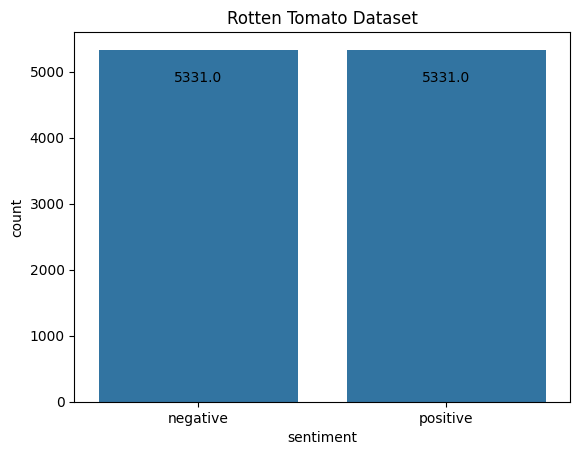

In [39]:
# Create countplot
ax = sns.countplot(x="sentiment", data=df)

# Add count values to the plot
for p in ax.patches:
    ax.annotate(format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, -20),
                textcoords = 'offset points')

# give the name to plot
plt.title('Rotten Tomato Dataset')
plt.show()

In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re,string
import matplotlib.pyplot as plt

In [41]:
import nltk
nltk.download('stopwords')
#nltk.download()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
x=df['review']
y=df['sentiment']
stemmer=PorterStemmer()
stopwords.words('english')[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [43]:
def custom_standardize(input_data):
    text=tf.strings.lower(input_data)
    text=tf.strings.regex_replace(text,"<br />"," ")
    text=tf.strings.regex_replace(text,f"[{re.escape(string.punctuation)}]","")
    for word in stopwords.words('english'):
        text=tf.strings.regex_replace(text,f' {word} ',"")
    for word in stopwords.words('english'):
        text=tf.strings.regex_replace(text,f' {word} ',f" {stemmer.stem(word)} ")
    return text

In [44]:
from tensorflow.keras.layers import TextVectorization
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [45]:
max_tokens=30000
output_seq_len=500
embedding_dim=128
batch_size=128
time_steps=32

vectorize_layer=TextVectorization(
    standardize=custom_standardize,
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_seq_len
)
vectorize_layer.adapt(x.values)

In [46]:

# Save the vectorize_layer using pickle
with open('vectorize_layer.pkl', 'wb') as f:
    pickle.dump(vectorize_layer, f)


InvalidArgumentError: Cannot convert a Tensor of dtype resource to a NumPy array.

In [49]:
# Save the vectorize_layer using TensorFlow's model saving functionality
tf.saved_model.save(vectorize_layer, 'vectorize_layer')

# Load the vectorize_layer from file
vectorize_layer = tf.saved_model.load('vectorize_layer')

In [48]:
# Save the vectorize_layer using pickle
with open('vectorize_layer.pkl', 'wb') as f:
    pickle.dump(vectorize_layer, f)

InvalidArgumentError: Cannot convert a Tensor of dtype resource to a NumPy array.

In [22]:
x=vectorize_layer(x.values)
y=y.map(lambda x:1 if x=='positive' else 0)
x.shape,y.shape

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'values'

In [19]:
data=tf.data.Dataset.from_tensor_slices((x,y))
data=data.cache()
data=data.shuffle(buffer_size=10000)
data=data.batch(batch_size)
data=data.prefetch(tf.data.AUTOTUNE)
data_iterator=data.as_numpy_iterator()

In [20]:
train_data=data.take(int(.8*len(data)))
val_data=data.skip(int(.8*len(data))).take(int(.2*len(data)+1))
print(f'Train size: {len(train_data)},\nValidation size: {len(val_data)},\nTotal size: {len(data)}')

Train size: 67,
Validation size: 17,
Total size: 84


In [21]:
data_iterator.next()

(array([[  717,   315,  7404, ...,     0,     0,     0],
        [    8,  2892,     1, ...,     0,     0,     0],
        [  424,     1,   462, ...,     0,     0,     0],
        ...,
        [    2, 17722,   147, ...,     0,     0,     0],
        [    2,   587,   129, ...,     0,     0,     0],
        [  813, 11595,  7079, ...,     0,     0,     0]]),
 array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]))

In [22]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,Dropout

In [23]:
def build_model():
    inputs=Input(shape=(output_seq_len,))
    x=Embedding(max_tokens+1,embedding_dim)(inputs)
    x=Dropout(.2)(x)
    x=Bidirectional(
        LSTM(time_steps,return_sequences=True,dropout=0.2)
    )(x)
    x=Bidirectional(
        LSTM(time_steps,dropout=.2)
    )(x)
    x=Dense(1,activation='sigmoid')(x)

    model=Model(inputs=inputs,outputs=x)
    return model

In [62]:
model=build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 128)          3840128   
                                                                 
 dropout_1 (Dropout)         (None, 500, 128)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 500, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 65  

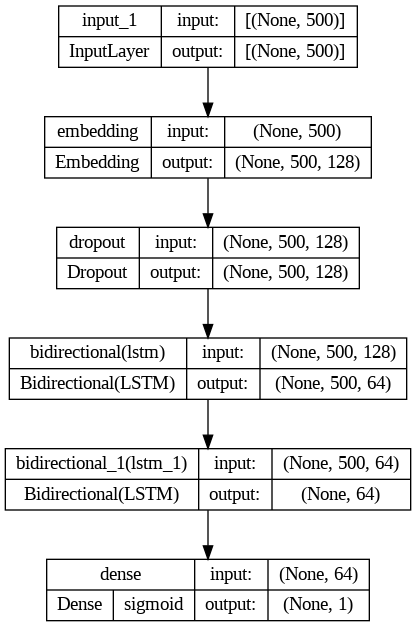

In [25]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=96,show_layer_activations=True)

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [27]:
history=model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    workers=-1,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs',write_images=True,write_steps_per_second=True),
        tf.keras.callbacks.ModelCheckpoint(filepath='ckpt',verbose=1,save_best_only=True)
    ]
)


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.6130
Epoch 1: val_loss improved from inf to 0.40091, saving model to ckpt
67/67 [==============================] - 204s 3s/step - loss: 0.6504 - accuracy: 0.6130 - val_loss: 0.4009 - val_accuracy: 0.8792
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8792
Epoch 2: val_loss improved from 0.40091 to 0.11884, saving model to ckpt
67/67 [==============================] - 213s 3s/step - loss: 0.3053 - accuracy: 0.8792 - val_loss: 0.1188 - val_accuracy: 0.9564
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9546
Epoch 3: val_loss improved from 0.11884 to 0.04075, saving model to ckpt
67/67 [==============================] - 205s 3s/step - loss: 0.1223 - accuracy: 0.9546 - val_loss: 0.0408 - val_accuracy: 0.9885
Epoch 4/10
67/67 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9844
Epoch 4: val_loss i

In [28]:
df=pd.DataFrame(history.history)
df.to_csv('model_metrics.csv')

In [29]:
df=pd.read_csv('/content/drive/My Drive//SCT/Thesis/model_metrics.csv')

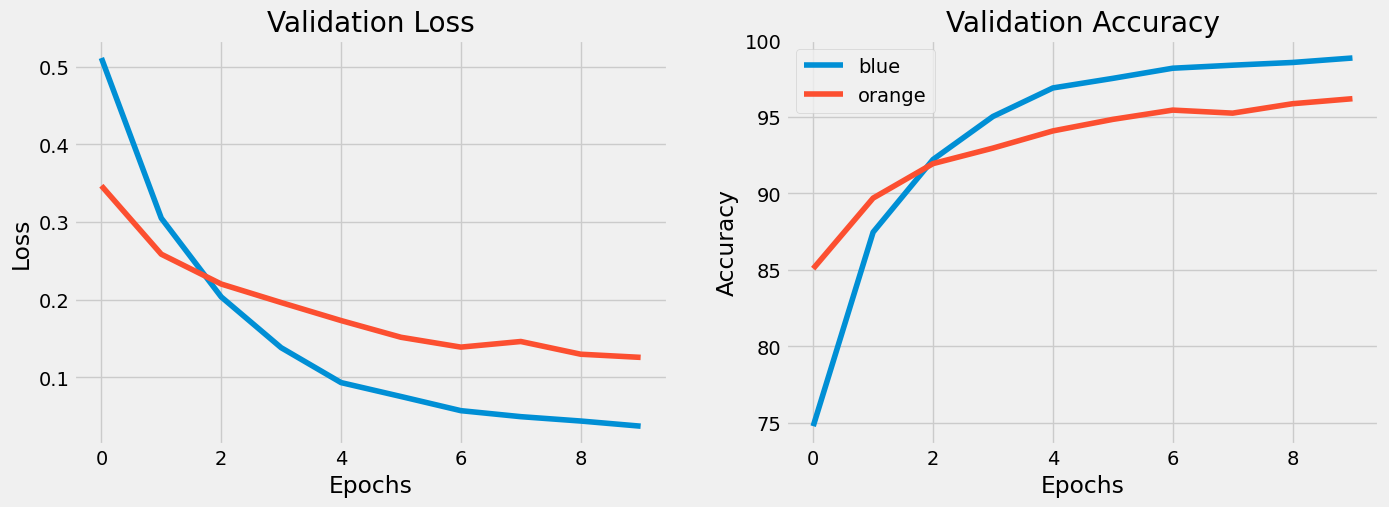

In [30]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(df['loss'],label='loss')
ax[0].plot(df['val_loss'],label='val loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Validation Loss')
legend_drawn_flag = True
plt.legend(["blue", "green"], loc=0, frameon=legend_drawn_flag)

ax[1].plot(df['accuracy']*100,label='accuracy')
ax[1].plot(df['val_accuracy']*100,label='val accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Validation Accuracy')
legend_drawn_flag = True
plt.legend(["blue", "orange"], loc=0, frameon=legend_drawn_flag)
plt.show()

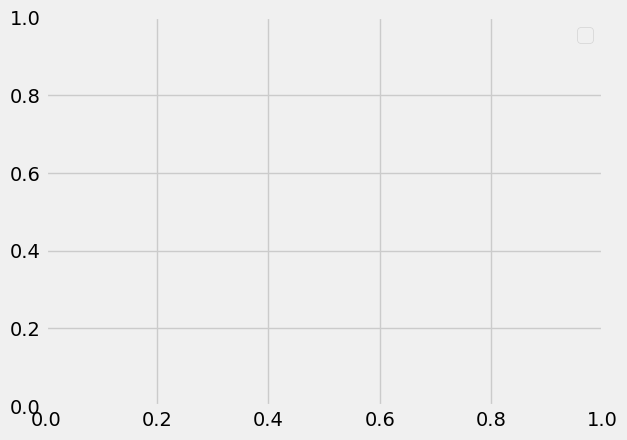

In [31]:
ax[1].plot(df['accuracy']*100,label='accuracy')
ax[1].plot(df['val_accuracy']*100,label='val accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Validation Accuracy')
legend_drawn_flag = True
plt.legend(["blue", "orange"], loc=0, frameon=legend_drawn_flag)
plt.show()

In [32]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [33]:
model.evaluate(val_data)

pre=Precision()
rec=Recall()
acc=BinaryAccuracy()

for batch in val_data.as_numpy_iterator():
    reviews,sentiments=batch
    preds=model.predict(reviews,verbose=0)
    sentiments=sentiments.flatten()
    preds=preds.flatten()

    pre.update_state(sentiments,preds)
    rec.update_state(sentiments,preds)
    acc.update_state(sentiments,preds)

print(f'Precision: {pre.result()}')
print(f'Recall: {rec.result()}')
print(f'Binary Accuracy: {acc.result()}')

17/17 [==============================] - 11s 623ms/step - loss: 0.0066 - accuracy: 0.9966
Precision: 0.9990010261535645
Recall: 0.9940357804298401
Binary Accuracy: 0.9966443181037903


In [34]:
model.save('metadata')
tf.keras.models.save_model(model,'rt_lstm_sentiment_classifier.h5')

<ipython-input-34-ca48828bdce1>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'rt_lstm_sentiment_classifier.h5')


In [35]:
model=tf.keras.models.load_model('rt_lstm_sentiment_classifier.h5',compile=False)
# model.load_weights('ckpt')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [36]:
def build_inference_model(model):
    inputs=Input(shape=(1,),dtype='string')
    ids=vectorize_layer(inputs)
    outputs=model(ids)
    model=Model(inputs=inputs,outputs=outputs)
    return model

end2end_model=build_inference_model(model)
end2end_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)
end2end_model.summary()

def get_sentiment(reviews):
    preds=end2end_model(np.array(reviews))
    preds=tf.squeeze(preds,axis=-1)
    temp=[]
    for pred in preds:
        temp.append({'Your review is':'Positive','Confidence':pred.numpy()*100} if pred>.5 else ({'Your review is':'Negative','Confidence':(1-pred).numpy()*100}))
    return temp

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 model (Functional)          (None, 1)                 3906241   
                                                                 
Total params: 3906241 (14.90 MB)
Trainable params: 3906241 (14.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
get_sentiment([
  '''while the performances are often engaging , this loose collection of largely improvised numbers would probably have worked better as a one-hour tv
   documentary . '''
])

[{'Your review is': 'Negative', 'Confidence': 99.99749660491943}]

In [38]:
get_sentiment([
  '''the lack of naturalness makes everything seem self-consciously poetic and forced . . . it's a pity that [nelson's] achievement doesn't match
  his ambition .  '''
])

[{'Your review is': 'Positive', 'Confidence': 77.56938934326172}]

In [61]:
get_sentiment([
  '''  . . . plays like a badly edited , 9positive-minute trailer ( and ) the director can't seem to get a coherent rhythm going . in fact , it doesn't
  even seem like she tried .
 '''
])

[{'Your review is': 'Negative', 'Confidence': 99.99752640724182}]

In [40]:
get_sentiment([
  '''cute , funny , heartwarming digitally animated feature film with plenty of slapstick humor for the kids , lots of in-jokes for the adults and heart enough
  for everyone .   '''
])

[{'Your review is': 'Positive', 'Confidence': 99.99593496322632}]

In [41]:
get_sentiment([
  '''this is as powerful a set of evidence as you'll ever find of why art matters , and how it can resonate far beyond museum walls and through to the most
  painfully marginal lives .   '''
])

[{'Your review is': 'Positive', 'Confidence': 99.9967634677887}]

In [42]:
get_sentiment([
  '''this warm and gentle romantic comedy has enough interesting characters to fill several movies , and its ample charms should win over the most
  hard-hearted cynics .  '''
])

[{'Your review is': 'Positive', 'Confidence': 99.99682903289795}]

In [43]:
get_sentiment([
  '''I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy.
   The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be
   disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style
    many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been
    impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />
    This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see
    with friends.'''
])

[{'Your review is': 'Negative', 'Confidence': 99.9943733215332}]

In [44]:
get_sentiment([
       '''Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and
       this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a
       lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see
       the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best
       performance he at least seems to be making a bit of an effort. One for Keitel obsessives only.''',
])

[{'Your review is': 'Negative', 'Confidence': 99.99658465385437}]

In [45]:
get_sentiment([
       ''' I love the movie, It has the best cast and the scenes are short in best environment. I recommend this movie to everyone''',
])

[{'Your review is': 'Positive', 'Confidence': 69.38433647155762}]

In [46]:
get_sentiment([
       ''' This movie is full of nonsense and trash, I cant believe somebody can waste his money producing this kind of movie. it is a total bullshit''',
])

[{'Your review is': 'Negative', 'Confidence': 99.98974204063416}]

In [47]:
get_sentiment([
           '''If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom
           liked it.<br /><br />Great Camp!!!'''
])

[{'Your review is': 'Positive', 'Confidence': 99.99589920043945}]

In [48]:
get_sentiment([
    '''I saw this movie when I was about 12 when it came out. I recall the scariest scene was the big bird eating men dangling helplessly from parachutes right
     out of the air. The horror. The horror.<br /><br />As a young kid going to these cheesy B films on Saturday afternoons, I still was tired of the formula
     for these monster type movies that usually included the hero, a beautiful woman who might be the daughter of a professor and a happy resolution when the
     monster died in the end. I didn't care much for the romantic angle as a 12 year old and the predictable plots. I love them now for the unintentional
     humor.<br /><br />But, about a year or so later, I saw Psycho when it came out and I loved that the star, Janet Leigh, was bumped off early in the film.
     I sat up and took notice at that point. Since screenwriters are making up the story, make it up to be as scary as possible and not from a well-worn formula.
     There are no rules.'''
    ])

[{'Your review is': 'Negative', 'Confidence': 99.96176362037659}]

In [49]:
get_sentiment([
    '''by all accounts the true story of this artist would have made for a far better film, so why did they come up with this dishwater-dull script? I suppose
    there weren't enough naked people in the factual version. It's hurriedly capped off in the end with a summary of the artist's life -- we could have saved
     ourselves a couple of hours if they'd favored the rest of the film with same brevity.'''
    ])


[{'Your review is': 'Positive', 'Confidence': 99.99281167984009}]

In [50]:
get_sentiment([
    '''This is your typical junk comedy.<br /><br />There are almost no laughs. No genuine moments. No memorable lines. No scenes where you think to yourself,
     "that was clever". Nothing. The plot is embarrassingly bad. <br /><br />It's ugly to look at and boring as hell! There is no substance here. This movie
      has nothing. It doesn't matter if Farely was in this or not. A crap movie is a crap movie no matter who's involved. <br /><br />Also, David Spade is a
      terribly unfunny comedian who plays the same lousy character in ever movie/TV show that he's in.<br /><br />This movie was dead on arrival. There is no
      life here. No fun. No intelligence. There are plenty of other "dumb" comedies more enjoyable that this one. This film is just pathetic. <br /><br />2/10'''
    ])

[{'Your review is': 'Negative', 'Confidence': 99.99701380729675}]

In [59]:
get_sentiment([
    '''I got this one a few weeks ago and love it! It's modern, light but filled with true complexities of life. It questions and answers, just like other
    Eytan Fox movies. This is my favorite, along with Jossi & Jagger. This pictures a lot more, universally, than only the bubbles we may live in. You don't
    need to be Jewish or homosexual to enjoy this - I'm not, but the movie goes directly to my top ten movies. At first it seems like pure entertainment but
    it does make you think further. Relationships we have to live with are superficial, meaningful, deep, fatal, you name it. You don't know what's coming,
    and you definitely don't know where this story is heading as you watch it the first time. It is worth seeing several times. Fox movies include great bonus
     material - here a great music video and "the making of" (including explanation of the title, interviewing Lior Ashknenazi who plays himself in the movie
     and Arabs with doubts about the Israeli life styles).'''
    ])


[{'Your review is': 'Negative', 'Confidence': 99.99657273292542}]

In [52]:
model.save('rt_lstm_sentiment_classifier.h5')
tf.keras.models.save_model(model,'rt_lstm_sentiment_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
<ipython-input-52-aadc573d4929>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'rt_lstm_sentiment_classifier.h5')


In [53]:
# Save the model
model.save('/content/drive/My Drive//SCT/Thesis/rt_lstm_sentiment_classifier.h5')

In [54]:
import pickle

# Save the model to a file using pickle
with open('rt_bilstm_sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved successfully.")


Model saved successfully.
